<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session6/EVA4S6_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# mount gdrive
mount_drive = False
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


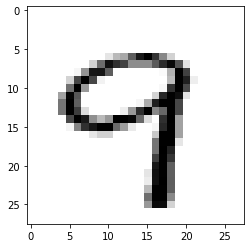

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy()) 

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

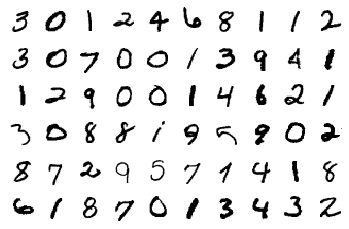

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Class

In [0]:
# Build the neural network, expand on top of nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.dropout_val = 0.10

        # Convolution block-1
        self.conv_blk1 = nn.Sequential(
            # input layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0,  bias=False),   #Output: 8X26X26, Jin=1, GRF: 3X3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),  #Output: 16X24X24, Jin=1, GRF: 5X5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), #Output: 16X22X22, Jin=1, GRF: 7X7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val)
        )

        # Transition Layer for Convolution block-1
        self.conv_blk1_transition = nn.Sequential(
            nn.MaxPool2d(2, 2),                                                                     #Output: 16X11X11, Jin=1, GRF: 8X8
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0,  bias=False),  #Output: 8X11X11 , Jin=2, GRF: 8X8 (combining channels)
        )

        # Convolution block-2
        self.conv_blk2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),  #Output: 16X9X9,  Jin=2, GRF: 12X12
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), #Output: 16X7X7, Jin=2, GRF: 16X16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False), #Output: 16X5X5, Jin=2, GRF: 20X20
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val)
        )

        # Output Block
        self.output_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),                                                             #Output: 16X1X1, Jin=2, GRF: 28X28
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0,  bias=False),  #Output: 10X1X1, Jin=2, GRF: 28X28 combining to 10 channels as we need 10 classes for predictions
            # no ReLU for last covv layer
            # No Batch Normalization
            # No Dropout
        ) # output_size = 1

    def forward(self, x):

        x = self.conv_blk1(x) # convolution block-1
        x = self.conv_blk1_transition(x)

        x = self.conv_blk2(x) # convolution block-2

        # output 
        x = self.output_block(x) # 

        # flatten the tensor so it can be passed to the dense layer afterward
        x = x.view(-1, 10)
        return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Utility Functions:
1. plotting model history: accuracy and losses
2. plotting model comparisions
3. plotting misclassified images for model

In [0]:
def plot_model_history(title_name, train_acc_hist, test_acc_hist, train_loss_hist, test_loss_hist, save_filename):
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    # summarize history for accuracy
    x_size = len(train_acc_hist)-1
    legend_list = ['train', 'test']

    axs[0].plot(range(1,x_size+1), train_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), test_acc_hist[1:])

    title = '{} - Accuracy'.format(title_name)
    axs[0].set_title(title)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
    axs[0].legend(legend_list, loc='best')

   # plot losses
    axs[1].plot(range(1,x_size+1),train_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),test_loss_hist[1:])

    title = '{} - Losses'.format(title_name)
    axs[1].set_title(title)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)
    axs[1].legend(legend_list, loc='best')
    plt.show()
    fig.savefig("{}.png".format(save_filename))


def plot_model_comparison(legend_list, model1_acc_hist, model1_loss_hist,
                          model2_acc_hist, model2_loss_hist,
                          model3_acc_hist, model3_loss_hist,
                          model4_acc_hist, model4_loss_hist,):
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    # summarize history for accuracy
    x_size = len(model1_acc_hist)-1

    axs[0].plot(range(1,x_size+1), model1_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), model2_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), model3_acc_hist[1:])
    axs[0].plot(range(1,x_size+1), model4_acc_hist[1:])

    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
    axs[0].legend(legend_list, loc='best')

   # plot losses
    axs[1].plot(range(1,x_size+1),model1_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),model2_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),model3_loss_hist[1:])
    axs[1].plot(range(1,x_size+1),model4_loss_hist[1:])
    axs[1].set_title('Model Losses')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)
    axs[1].legend(legend_list, loc='best')
    plt.show()
    fig.savefig("model_compare.png")

def get_test_accuracy(model, device, testloader):
    model.eval()
    correct = 0
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Accuracy: {:.2f}%\n'.format(acc))
    return

def plot_misclassified_images(model, device, testloader, num_of_images = 25, save_filename="misclassified"):
    model.eval()
    misclassified_cnt = 0
    fig = plt.figure(figsize=(12,12))
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)     # get the index of the max log-probability
        pred_marker = pred.eq(target.view_as(pred))   
        wrong_idx = (pred_marker == False).nonzero()  # get indices for wrong predictions
        for idx in wrong_idx:
          index = idx[0].item()
          title = "Target:{}, Pred:{}".format(target[index].item(), pred[index][0].item())
          #print(title)
          ax = fig.add_subplot(5, 5, misclassified_cnt+1, xticks=[], yticks=[])
          #ax.axis('off')
          ax.set_title(title)
          plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
          
          misclassified_cnt += 1
          if(misclassified_cnt==num_of_images):
            break
        
        if(misclassified_cnt==num_of_images):
            break

    fig.savefig("{}.png".format(save_filename))
    return

# Relularization Functions

In [0]:
def L1_Loss_calc(model, factor=0.0005):
  l1_crit = nn.L1Loss(size_average=False)
  reg_loss = 0
  for param in model.parameters():
    #zero_vector = torch.rand_like(param)*0
    zero_vector=torch.zeros_like(param)
    reg_loss += l1_crit(param,zero_vector)

  return factor * reg_loss

# Common functions for train, test and build model

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, L1_loss_enable=False):
  model.train()
  pbar = tqdm(train_loader)
  train_loss = 0
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if(L1_loss_enable == True):
      regloss = L1_Loss_calc(model, 0.0005)
      regloss /= len(data) # by batch size
      loss += regloss

    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item():0.6f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    pbar.set_description(desc= f'Loss={train_loss/(batch_idx+1):0.6f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_loss /= len(train_loader)
  acc = 100. * correct/len(train_loader.dataset) #processed # 
  return np.round(acc,2), np.round(train_loss,6)

def test(model, device, test_loader, L1_loss_enable=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        if(L1_loss_enable == True):
          regloss = L1_Loss_calc(model, 0.0005)
          regloss /= len(test_loader.dataset) # by batch size which is here total test dataset size
          test_loss += regloss

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    acc = 100. * correct / len(test_loader.dataset)
    return np.round(acc,2), test_loss

def build_model(model, device, trainloader, testloader, epochs, L1_loss_flag=False, L2_penalty_val=0):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=L2_penalty_val)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  for epoch in range(epochs):
    print("EPOCH:", epoch)
    acc, loss = train(model, device, trainloader, optimizer, epoch, L1_loss_flag)
    train_acc.append(acc)
    train_losses.append(loss)

    scheduler.step()

    acc, loss = test(model, device, testloader, L1_loss_flag)
    test_acc.append(acc)
    test_losses.append(loss)
  
  return train_acc, train_losses, test_acc, test_losses


# Model without L1 and L2

In [0]:
EPOCHS = 40
model_name = "Model without L1 and L2"

In [0]:
model_name = "Model without L1 and L2"
model_without_l1_l2 =  Net().to(device)
train_acc1, train_losses1, test_acc1, test_losses1 = build_model(model_without_l1_l2, 
                                                                 device, 
                                                                 trainloader=train_loader, 
                                                                 testloader=test_loader, 
                                                                 epochs=EPOCHS)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.077283, Accuracy: 9786/10000 (97.86%)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.052978, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.041361, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.038319, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.032529, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.027452, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.030126, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.027594, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.027315, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.024101, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021648, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020760, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021035, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021069, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020913, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020653, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020633, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020799, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021012, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020097, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020741, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020129, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020095, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020737, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020284, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.019827, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.019959, Accuracy: 9938/10000 (99.38%)

EPOCH: 27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020791, Accuracy: 9937/10000 (99.37%)

EPOCH: 28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020273, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020223, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020306, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020884, Accuracy: 9936/10000 (99.36%)

EPOCH: 32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.019608, Accuracy: 9942/10000 (99.42%)

EPOCH: 33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020770, Accuracy: 9936/10000 (99.36%)

EPOCH: 34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020762, Accuracy: 9937/10000 (99.37%)

EPOCH: 35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020028, Accuracy: 9938/10000 (99.38%)

EPOCH: 36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.019549, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020207, Accuracy: 9941/10000 (99.41%)

EPOCH: 38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020223, Accuracy: 9936/10000 (99.36%)

EPOCH: 39


Loss=0.027283 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]



Test set: Average loss: 0.020411, Accuracy: 9936/10000 (99.36%)




Ploting Accuracy and Loss history: Model without L1 and L2



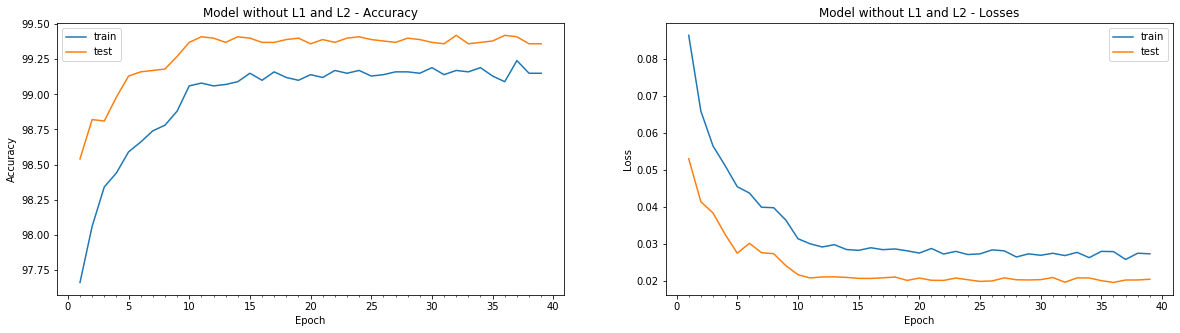

In [0]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))

plot_model_history(model_name, 
                   train_acc1,test_acc1,
                   train_losses1,test_losses1,
                   save_filename = "model_without_l1_l2_history")


Ploting misclassified images: Model without L1 and L2



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


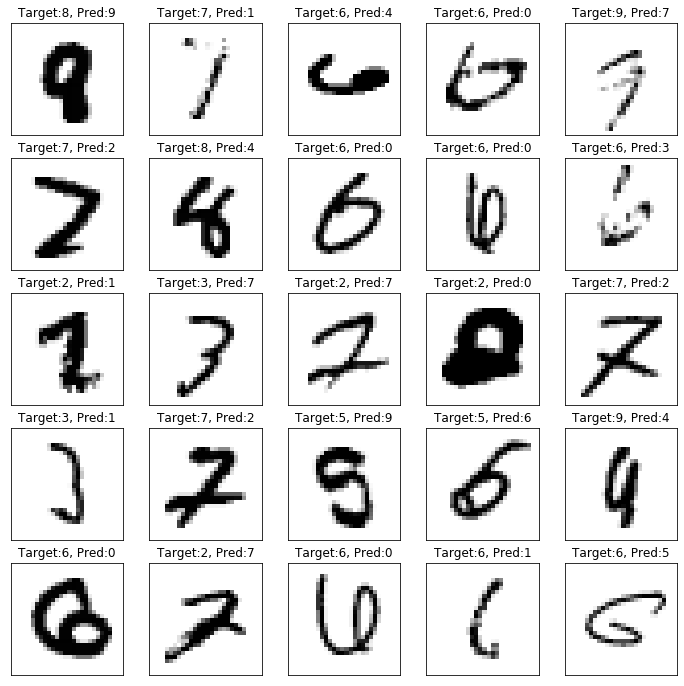

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))

plot_misclassified_images(model_without_l1_l2, 
                          device, 
                          testloader=test_loader,
                          save_filename="model_without_l1_l2_misclassified")

# Model with L1

In [0]:
model_name = "Model with L1"
model_with_l1 =  Net().to(device)
train_acc2, train_losses2, test_acc2, test_losses2 = build_model(model_with_l1, 
                                                                 device, 
                                                                 trainloader=train_loader, 
                                                                 testloader=test_loader, 
                                                                 epochs=EPOCHS,
                                                                 L1_loss_flag=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.112762, Accuracy: 9660/10000 (96.60%)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.051808, Accuracy: 9837/10000 (98.37%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.035492, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.030332, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.027988, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.023563, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021255, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.024667, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.020347, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021401, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.017851, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.017121, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016742, Accuracy: 9950/10000 (99.50%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016855, Accuracy: 9950/10000 (99.50%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016396, Accuracy: 9951/10000 (99.51%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016490, Accuracy: 9956/10000 (99.56%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016727, Accuracy: 9950/10000 (99.50%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016348, Accuracy: 9953/10000 (99.53%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.017127, Accuracy: 9953/10000 (99.53%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016537, Accuracy: 9950/10000 (99.50%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016440, Accuracy: 9957/10000 (99.57%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016201, Accuracy: 9959/10000 (99.59%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016086, Accuracy: 9956/10000 (99.56%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.015803, Accuracy: 9958/10000 (99.58%)

EPOCH: 24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016184, Accuracy: 9955/10000 (99.55%)

EPOCH: 25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.015881, Accuracy: 9958/10000 (99.58%)

EPOCH: 26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016025, Accuracy: 9956/10000 (99.56%)

EPOCH: 27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016254, Accuracy: 9957/10000 (99.57%)

EPOCH: 28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.015931, Accuracy: 9958/10000 (99.58%)

EPOCH: 29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016229, Accuracy: 9956/10000 (99.56%)

EPOCH: 30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.015956, Accuracy: 9955/10000 (99.55%)

EPOCH: 31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016582, Accuracy: 9954/10000 (99.54%)

EPOCH: 32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016432, Accuracy: 9954/10000 (99.54%)

EPOCH: 33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.015718, Accuracy: 9958/10000 (99.58%)

EPOCH: 34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016628, Accuracy: 9956/10000 (99.56%)

EPOCH: 35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016048, Accuracy: 9955/10000 (99.55%)

EPOCH: 36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.015919, Accuracy: 9956/10000 (99.56%)

EPOCH: 37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016222, Accuracy: 9956/10000 (99.56%)

EPOCH: 38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.016147, Accuracy: 9957/10000 (99.57%)

EPOCH: 39


Loss=0.029885 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 33.42it/s]



Test set: Average loss: 0.016240, Accuracy: 9957/10000 (99.57%)




Ploting Accuracy and Loss history: Model with L1



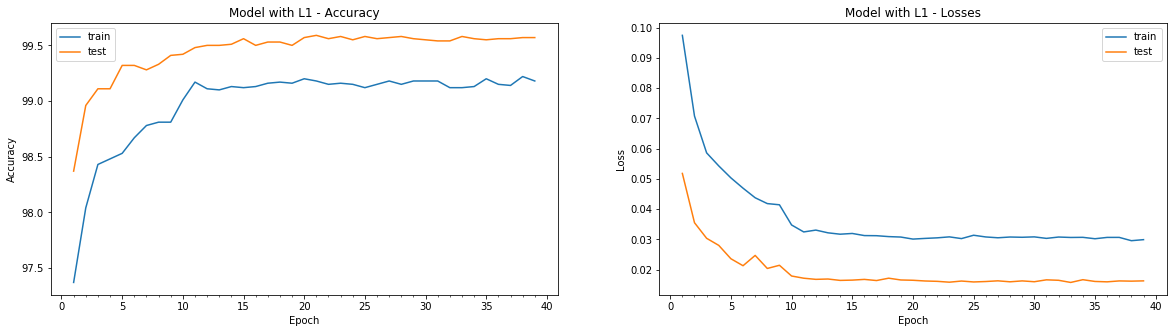

In [0]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))

plot_model_history(model_name, 
                   train_acc2,test_acc2,
                   train_losses2,test_losses2,
                   save_filename = "model_with_l1_history")


Ploting misclassified images: Model with L1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


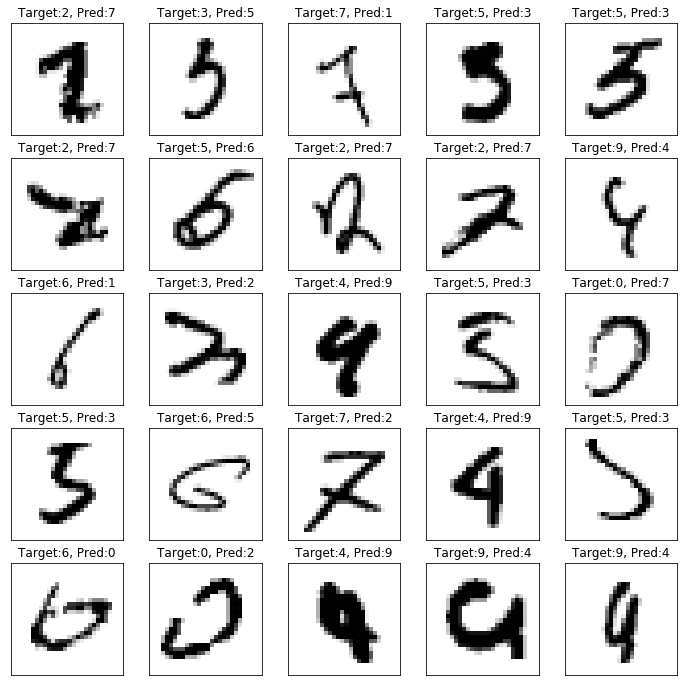

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))

plot_misclassified_images(model_with_l1, 
                          device, 
                          testloader=test_loader,
                          save_filename="model_with_l1_misclassified")

# Model with L2

In [0]:
model_name = "Model with L2"
model_with_l2 =  Net().to(device)
train_acc3, train_losses3, test_acc3, test_losses3 = build_model(model_with_l2, 
                                                                 device, 
                                                                 trainloader=train_loader, 
                                                                 testloader=test_loader, 
                                                                 epochs=EPOCHS,
                                                                 L2_penalty_val=0.001)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.073918, Accuracy: 9802/10000 (98.02%)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.050218, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.040914, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.038093, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.041028, Accuracy: 9867/10000 (98.67%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.036889, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.032285, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.036916, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.032749, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.029880, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.024057, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.023896, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022117, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022657, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022886, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022285, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022816, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.023967, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.023814, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021862, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021969, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022082, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022284, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022277, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022804, Accuracy: 9938/10000 (99.38%)

EPOCH: 25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021729, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022200, Accuracy: 9942/10000 (99.42%)

EPOCH: 27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021388, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022386, Accuracy: 9938/10000 (99.38%)

EPOCH: 29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022250, Accuracy: 9943/10000 (99.43%)

EPOCH: 30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022294, Accuracy: 9941/10000 (99.41%)

EPOCH: 31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022178, Accuracy: 9942/10000 (99.42%)

EPOCH: 32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022522, Accuracy: 9937/10000 (99.37%)

EPOCH: 33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022050, Accuracy: 9942/10000 (99.42%)

EPOCH: 34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022096, Accuracy: 9942/10000 (99.42%)

EPOCH: 35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022093, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022402, Accuracy: 9941/10000 (99.41%)

EPOCH: 37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021963, Accuracy: 9943/10000 (99.43%)

EPOCH: 38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021722, Accuracy: 9946/10000 (99.46%)

EPOCH: 39


Loss=0.030748 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]



Test set: Average loss: 0.021610, Accuracy: 9944/10000 (99.44%)




Ploting Accuracy and Loss history: Model with L2



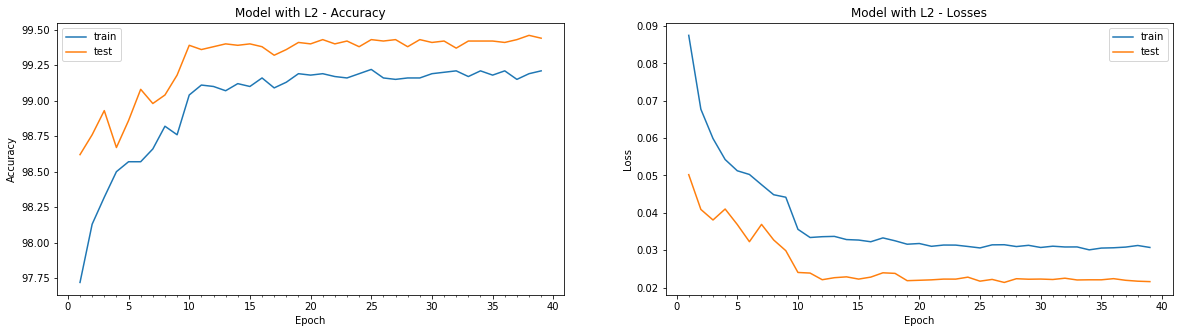

In [0]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))

plot_model_history(model_name, 
                   train_acc3,test_acc3,
                   train_losses3,test_losses3,
                   save_filename = "model_with_l2_history")


Ploting misclassified images: Model with L2



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


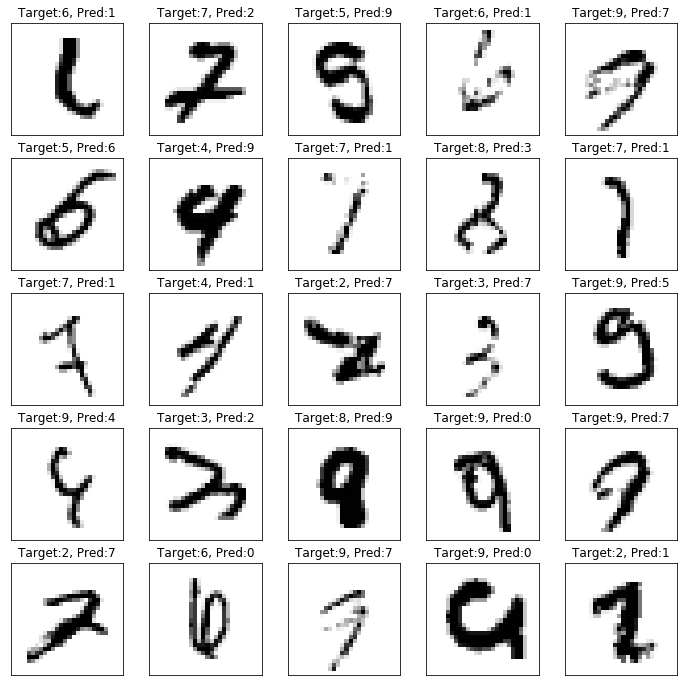

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))

plot_misclassified_images(model_with_l2, 
                          device, 
                          testloader=test_loader,
                          save_filename="model_with_l2_misclassified")

# Model with L1 and L2

In [0]:
model_name = "Model with L1 and L2"
model_with_l1_l2 =  Net().to(device)
train_acc4, train_losses4, test_acc4, test_losses4 = build_model(model_with_l1_l2, 
                                                                 device, 
                                                                 trainloader=train_loader, 
                                                                 testloader=test_loader, 
                                                                 epochs=EPOCHS,
                                                                 L1_loss_flag=True, 
                                                                 L2_penalty_val=0.001)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.073444, Accuracy: 9820/10000 (98.20%)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.047543, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.041875, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.033290, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.035797, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.030440, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.031612, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.026603, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.031554, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.029107, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022265, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022789, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022952, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.023283, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022132, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022156, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022174, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022221, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021666, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022688, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022067, Accuracy: 9925/10000 (99.25%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022345, Accuracy: 9926/10000 (99.26%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021964, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021888, Accuracy: 9927/10000 (99.27%)

EPOCH: 24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021878, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021825, Accuracy: 9929/10000 (99.29%)

EPOCH: 26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021919, Accuracy: 9928/10000 (99.28%)

EPOCH: 27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021967, Accuracy: 9930/10000 (99.30%)

EPOCH: 28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022156, Accuracy: 9928/10000 (99.28%)

EPOCH: 29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022291, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022627, Accuracy: 9933/10000 (99.33%)

EPOCH: 31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021984, Accuracy: 9929/10000 (99.29%)

EPOCH: 32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021802, Accuracy: 9929/10000 (99.29%)

EPOCH: 33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021897, Accuracy: 9929/10000 (99.29%)

EPOCH: 34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021924, Accuracy: 9929/10000 (99.29%)

EPOCH: 35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021530, Accuracy: 9929/10000 (99.29%)

EPOCH: 36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.021805, Accuracy: 9930/10000 (99.30%)

EPOCH: 37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022085, Accuracy: 9929/10000 (99.29%)

EPOCH: 38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.022284, Accuracy: 9930/10000 (99.30%)

EPOCH: 39


Loss=0.034646 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]



Test set: Average loss: 0.022000, Accuracy: 9929/10000 (99.29%)




Ploting Accuracy and Loss history: Model with L1 and L2



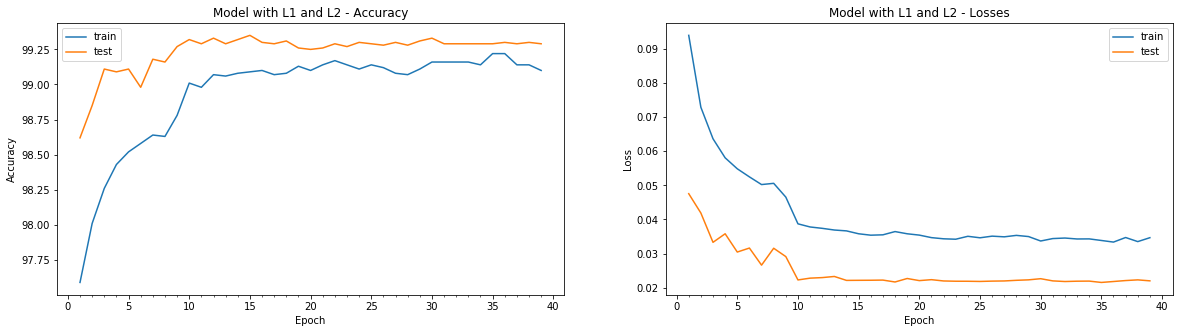

In [0]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))

plot_model_history(model_name, 
                   train_acc4,test_acc4,
                   train_losses4,test_losses4,
                   save_filename = "model_with_l1_l2_history")


Ploting misclassified images: Model with L1 and L2



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


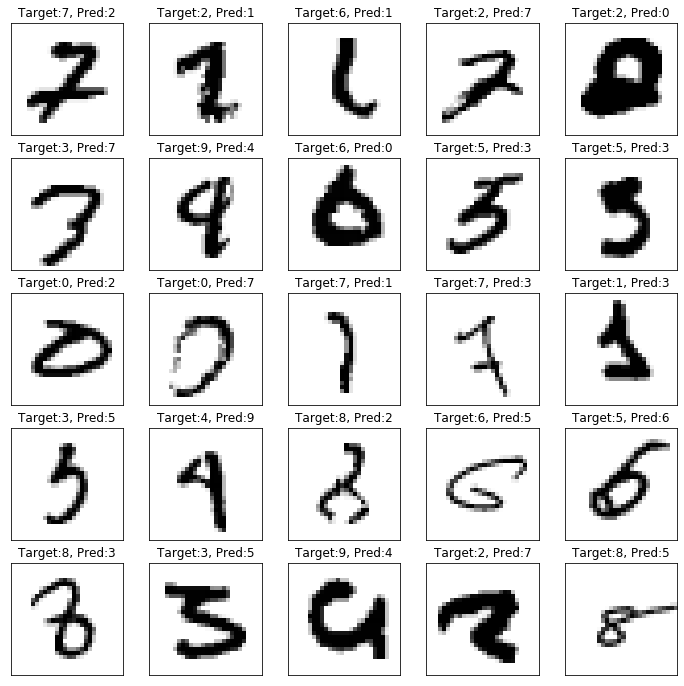

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))

plot_misclassified_images(model_with_l1_l2, 
                          device, 
                          testloader=test_loader,
                          save_filename="model_with_l1_l2_misclassified")

# Compare all models: Plot validation Accuracy and validation loss changes for all models together 

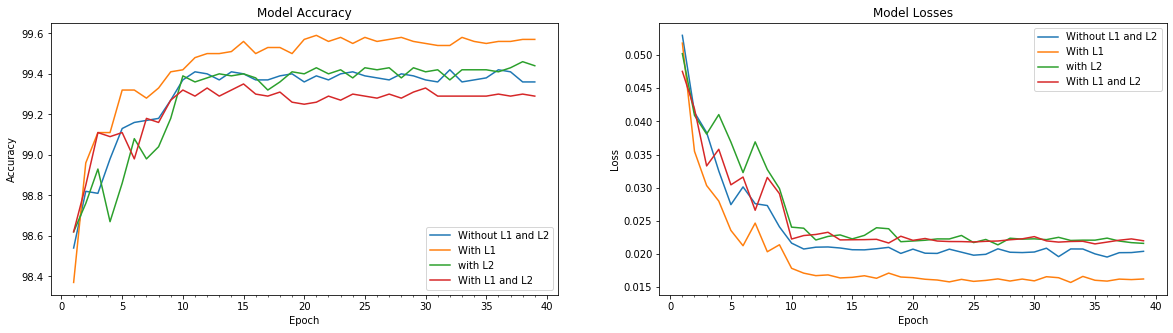

In [0]:
legend_list = ["Without L1 and L2", "With L1", "with L2", "With L1 and L2"]
plot_model_comparison(legend_list,
                      test_acc1, test_losses1,
                      test_acc2, test_losses2,
                      test_acc3, test_losses3,
                      test_acc4, test_losses4)